In [9]:
import os
import lifelines
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

## Load Raw Data

In [10]:
folder_data = 'data/'
fn_data = 'tmb_mskcc_2018_clinical_data.tsv'
fp_data = os.path.join(folder_data, fn_data)

KEY_SURVIVAL_MONTH = 'Overall Survival (Months)'
KEY_CANCER_TYPE = 'Cancer Type'
KEY_DRUG_TYPE = 'Drug Type'
KEY_PATIENT_ID = 'Patient ID'
KEY_OVERALL_STATUS = 'Overall Survival Status'
KEY_EVENT = 'Event'

In [11]:
raw_data_df = pd.read_csv(fp_data, sep='\t', index_col=1)
print('Number of records:', raw_data_df.shape[0])

event = np.zeros(len(raw_data_df), dtype=np.int32)
event[raw_data_df[KEY_OVERALL_STATUS] == '1:DECEASED'] = 1
raw_data_df[KEY_EVENT] = event
raw_data_df.head(4)

Number of records: 1661


,Study ID,Sample ID,Age at Which Sequencing was Reported (Days),Age Group at Diagnosis in Years,Cancer Type,Cancer Type Detailed,Drug Type,Gene Panel,Institute Source,Metastatic Site,...,Primary Tumor Site,Sample Class,Number of Samples Per Patient,Sample coverage,Sample Type,Sex,Somatic Status,TMB Score,Tumor Purity,Event
Patient ID,,,,,,,,,,,,,,,,,,,,,
P-0000057,tmb_mskcc_2018,P-0000057-T01-IM3,41.0,31-50,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,Breast,Tumor,1,835,Primary,Female,Matched,5.580000,25,1
P-0000062,tmb_mskcc_2018,P-0000062-T01-IM3,80.0,>71,Esophagogastric Cancer,Adenocarcinoma of the Gastroesophageal Junction,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,Esophagus,Tumor,1,1176,Primary,Male,Matched,6.691462,30,1
P-0000063,tmb_mskcc_2018,P-0000063-T01-IM3,62.0,61-70,Bladder Cancer,Bladder Urothelial Carcinoma,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,Bladder,Tumor,1,900,Primary,Male,Matched,16.728656,70,0
P-0000071,tmb_mskcc_2018,P-0000071-T01-IM3,66.0,61-70,Bladder Cancer,Bladder Urothelial Carcinoma,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,Bladder,Tumor,1,795,Primary,Male,Matched,11.152437,30,0


## Constructure the time series dataframe and check matrix rank

In [12]:
# Ken's utility functions
def get_km_estimate(df, target_length=None):
    """
    Fit a Kaplan-Meier estimate of the time to event from the given dataframe, using
    columns KEY_SURVIVAL_MONTH and KEY_EVENT.  The latter is coded as an indicator 
    for the event of interest occurring.  If target_length is provided, then truncate
    or pad (with np.nan) the survival function estimate to that length.
    Returns: survival function estimates.
    """
    kmf = lifelines.KaplanMeierFitter()
    kmf.fit(df[KEY_SURVIVAL_MONTH], df[KEY_EVENT])
    S_hat = kmf.survival_function_['KM_estimate'].values
    if target_length is not None:
        if len(S_hat) > target_length:
            S_hat = S_hat[:target_length]
        elif len(S_hat) < target_length:
            S_hat = np.pad(S_hat, (0, target_length - len(S_hat)), constant_values=np.nan)
    return S_hat

def get_hazard_estimate(df, target_length=None):
    """
    Fit a Nelson-Aalen estimate of the cumulative hazard function from the given dataframe,
    using columns KEY_SURVIVAL_MONTH and KEY_EVENT.  The latter is coded as an indicator
    for the event of interest occurring.  If target length is provided, then truncate
    or pad (with np.nan) the estimate to that length.
    Returns: N-A estimate of the cumulative hazard function.
    """
    naf = lifelines.NelsonAalenFitter()
    naf.fit(df[KEY_SURVIVAL_MONTH], df[KEY_EVENT])
    h_hat = naf.cumulative_hazard_['NA_estimate'].values
    if target_length is not None:
        if len(h_hat) > target_length:
            h_hat = h_hat[:target_length]
        elif len(h_hat) < target_length:
            h_hat = np.pad(h_hat, (0, target_length - len(h_hat)), constant_values=np.nan)
    return h_hat

In [13]:
def construct_ts_matrix(data_df, unit_defined_by=None, filter_by_column=None,
                        target_length=12):
    """Returns a time series matrix for units.
    
    Args:
      data_df: The input dataframe.
      unit_defined_by: A column whose values will be used to group the rows of data_df to form units.
        If None, each row will be one unit.
      filter_by_column: A dict where the keys are column names and values are column values. If given,
        only rows with the matched column values are kept.
      target_length: 
    """
    if filter_by_column:
      to_keep = None  
      for k,v in filter_by_column.items():
        if to_keep is None:
          to_keep = (data_df[k] == v)
        else:
          to_keep = (to_keep & (data_df[k] == v))
      data_df = data_df[to_keep]
    
    # Next, besides survival data, we only keep the column used to define units.
    data_df = data_df[[unit_defined_by, KEY_SURVIVAL_MONTH, KEY_EVENT]]
    units = sorted(list(set(data_df[unit_defined_by])))
    columns = range(1, target_length+1) 
    km_df = None
    hz_df = None
    for i, u in enumerate(units):
      data = data_df[data_df[unit_defined_by]==u]
    
      kmf = lifelines.KaplanMeierFitter()
      kmf.fit(data[KEY_SURVIVAL_MONTH], data[KEY_EVENT])
      S_hat = kmf.survival_function_['KM_estimate'].values
    
      naf = lifelines.NelsonAalenFitter()
      naf.fit(data[KEY_SURVIVAL_MONTH], data[KEY_EVENT])
      h_hat = naf.cumulative_hazard_['NA_estimate'].values
    
      if len(S_hat) < target_length:
        continue

      if km_df is None:
        km_df = pd.DataFrame(data=[S_hat[:target_length]], index=[u], columns=columns)
      else:
        new_km_row = pd.DataFrame(data=[S_hat[:target_length]], index=[u], columns=columns)
        km_df = km_df.append(new_km_row)   
        
      if hz_df is None:
        hz_df = pd.DataFrame(data=[h_hat[:target_length]], index=[u], columns=columns)
      else:
        new_hz_row = pd.DataFrame(data=[h_hat[:target_length]], index=[u], columns=columns)
        hz_df = hz_df.append(new_hz_row)
        
    return km_df, hz_df

def plot_spectrum(ts_matrix):
  (U, s, Vh) = np.linalg.svd((ts_matrix) - np.mean(ts_matrix))
  s2 = np.power(s, 2)
  spectrum = np.cumsum(s2)/np.sum(s2)

  plt.plot(spectrum)
  plt.grid()
  plt.title("Cumulative energy")
  plt.figure()
  plt.plot(s2)
  plt.grid()
  plt.xlabel("Ordered Singular Values") 
  plt.ylabel("Energy")
  plt.title("Singular Value Spectrum")


def analyze_ts_matrix_rank(data_df, drug_type, data_type='km', target_length=12):
  km_df, hz_df = construct_ts_matrix(
      data_df,
      unit_defined_by=KEY_CANCER_TYPE,
      filter_by_column={KEY_DRUG_TYPE:drug_type},
      target_length=target_length)
  if data_type == 'km':
    plot_spectrum(km_df)
    return km_df
  elif data_type == 'hazard':
    plot_spectrum(hz_df)
    return hz_df

(7, 24)


,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
Bladder Cancer,0.989583,0.958168,0.909721,0.849800,0.803864,0.780046,0.737052,0.697211,0.682982,0.644612,...,0.546154,0.504935,0.493459,0.481123,0.455800,0.414364,0.414364,0.414364,0.396348,0.396348
Colorectal Cancer,1.000000,0.979798,0.919192,0.876439,0.832062,0.787086,0.775160,0.713640,0.701120,0.661434,...,0.539263,0.519290,0.519290,0.495686,0.495686,0.495686,0.495686,0.460280,0.460280,0.460280
Glioma,0.991228,0.982378,0.928794,0.893071,0.847966,0.775799,0.730164,0.702782,0.656547,0.608271,...,0.422849,0.368638,0.297289,0.272515,0.245263,0.231637,0.204386,0.177135,0.144928,0.144928
Head and Neck Cancer,1.000000,0.977099,0.884775,0.828471,0.767426,0.740963,0.713854,0.666890,0.607169,0.566005,...,0.406892,0.386547,0.386547,0.386547,0.358937,0.358937,0.326306,0.290050,0.217537,0.217537


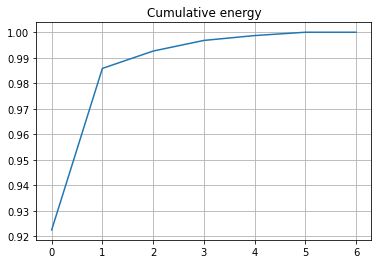

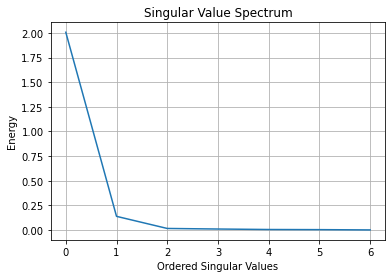

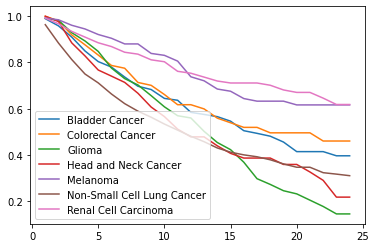

In [14]:
ts_pd1_df = analyze_ts_matrix_rank(raw_data_df, 'PD-1/PDL-1', data_type='km', target_length=24)
ts_pd1_df.transpose().plot()
ts_pd1_df.to_csv('data/km_pd1_df.csv', index_label='Cancer Type', index=True)
print(ts_pd1_df.shape)
ts_pd1_df.head(4)

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
Bladder Cancer,0.010444,0.042618,0.094354,0.162281,0.217658,0.247623,0.304089,0.359402,0.379916,0.437402,...,0.601895,0.679602,0.702329,0.727329,0.780672,0.874483,0.874483,0.874483,0.917961,0.917961
Colorectal Cancer,0.000000,0.020305,0.083818,0.131163,0.182787,0.237973,0.253124,0.335135,0.352679,0.410386,...,0.611533,0.648570,0.648570,0.694025,0.694025,0.694025,0.694025,0.765453,0.765453,0.765453
Glioma,0.008772,0.017701,0.073529,0.112558,0.164115,0.252569,0.312828,0.350807,0.418399,0.494191,...,0.854286,0.989619,1.200906,1.286051,1.388683,1.444238,1.565562,1.703657,1.894566,1.894566
Head and Neck Cancer,0.000000,0.023078,0.121923,0.187367,0.263489,0.298376,0.335417,0.403009,0.496098,0.565689,...,0.891333,0.941333,0.941333,0.941333,1.012762,1.012762,1.103671,1.214782,1.482639,1.482639


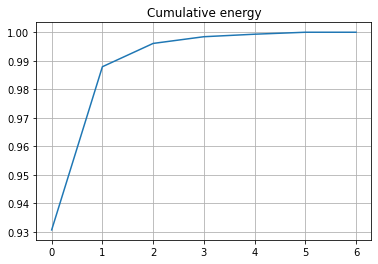

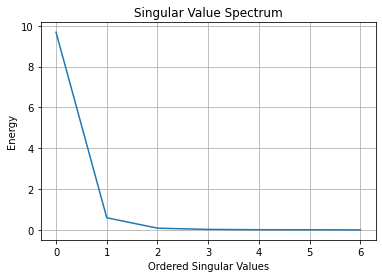

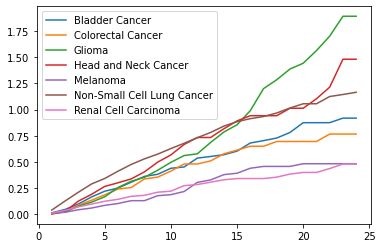

In [15]:
ts_pd1_df = analyze_ts_matrix_rank(raw_data_df, 'PD-1/PDL-1', data_type='hazard', target_length=24)
ts_pd1_df.transpose().plot()
ts_pd1_df.to_csv('data/hz_pd1_df.csv', index_label='Cancer Type', index=True)
print(ts_pd1_df.shape)
ts_pd1_df.head(4)

(4, 18)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Bladder Cancer,1.000000,0.956522,0.913043,0.869565,0.826087,0.826087,0.777494,0.673828,0.673828,0.617675,0.561523,0.505371,0.505371,0.505371,0.505371,0.421142,0.421142,0.421142
Melanoma,0.991304,0.939130,0.904348,0.895652,0.869309,0.860529,0.851748,0.834186,0.825312,0.816437,0.807563,0.780940,0.754317,0.736141,0.736141,0.736141,0.725624,0.725624
Non-Small Cell Lung Cancer,1.000000,0.952381,0.809524,0.761905,0.761905,0.761905,0.761905,0.703297,0.644689,0.586081,0.586081,0.586081,0.586081,0.586081,0.586081,0.468864,0.468864,0.468864
Renal Cell Carcinoma,1.000000,1.000000,0.964286,0.928571,0.892857,0.857143,0.821429,0.821429,0.784091,0.746753,0.746753,0.746753,0.746753,0.746753,0.746753,0.746753,0.663781,0.663781


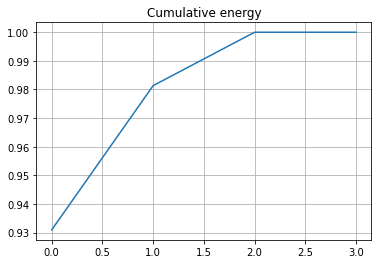

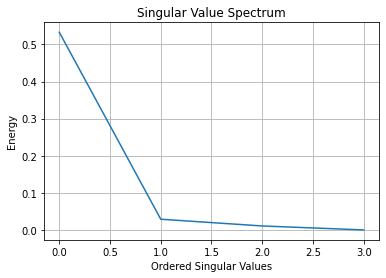

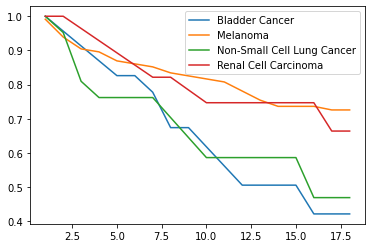

In [24]:
ts_combo_df = analyze_ts_matrix_rank(raw_data_df, 'Combo', data_type='km', target_length=18)
ts_combo_df.transpose().plot()
ts_combo_df.to_csv('data/km_combo_df.csv', index_label='Cancer Type', index=True)
print(ts_combo_df.shape)
ts_combo_df.head(4)

(4, 18)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Bladder Cancer,0.000000,0.043478,0.088933,0.136552,0.186552,0.186552,0.245375,0.383471,0.383471,0.466804,0.557713,0.657713,0.657713,0.657713,0.657713,0.824380,0.824380,0.824380
Melanoma,0.008696,0.062520,0.100083,0.109698,0.139403,0.149504,0.159708,0.180434,0.191072,0.201825,0.212695,0.246031,0.280517,0.304760,0.304760,0.304760,0.319046,0.319046
Non-Small Cell Lung Cancer,0.000000,0.047619,0.205806,0.264630,0.264630,0.264630,0.264630,0.341553,0.424886,0.515795,0.515795,0.515795,0.515795,0.515795,0.515795,0.715795,0.715795,0.715795
Renal Cell Carcinoma,0.000000,0.000000,0.035714,0.072751,0.111213,0.151213,0.192880,0.192880,0.238334,0.285953,0.285953,0.285953,0.285953,0.285953,0.285953,0.285953,0.397064,0.397064


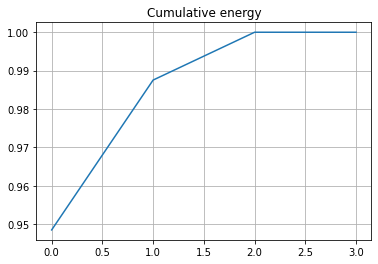

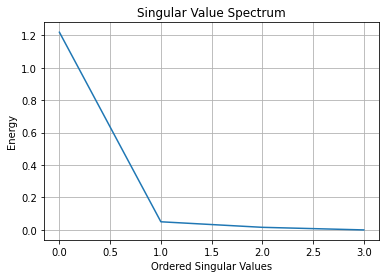

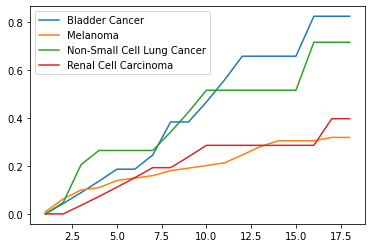

In [25]:
ts_combo_df = analyze_ts_matrix_rank(raw_data_df, 'Combo', data_type='hazard', target_length=18)
ts_combo_df.transpose().plot()
ts_combo_df.to_csv('data/hz_combo_df.csv', index_label='Cancer Type', index=True)
print(ts_combo_df.shape)
ts_combo_df.head(4)